In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests

import seaborn as sns

plt.rcParams['figure.facecolor'] = 'white'

In [2]:
from IPython.display import display
from scipy.stats import spearmanr

In [3]:
wordlist = pd.read_csv("data/image_word.csv")
wordlist.tail(2)

,image,stimulus,url,food.item
136,Yogurt-pretzels.jpg,yogurt pretzels,https://voices.uchicago.edu/bakkourlab/files/2...,yogurt pretzels
137,Yogurt-with-granola-strawberries.jpg,yogurt no spoon,https://voices.uchicago.edu/bakkourlab/files/2...,yogurt with granola & strawberries


In [4]:
# datast constants
fixation = 0
target = 1
repeat = 2
filler = 3
vigilance = 4

hit = 11
miss = 12
false_alarm = 13
correct_rejection = 14

target_hit = 211
target_FA = 113
target_miss = 212
target_correct_rej = 114

In [5]:
def preprocess(expt, mem_data):

    im = wordlist["image"] if expt == 1 else wordlist["food.item"]
    total = np.zeros((len(mem_data), len(wordlist),  4)) # istarget, Hit, False alarm, correct recognition
    
    for participant in range(len(mem_data)):

        image_seq = mem_data.iloc[participant]["Answer.imseq"].split(",")
        image_seq = [ image_seq[i] for i in range(0, len(image_seq), 2)]

        values_seq = [ int(i) for i in mem_data.iloc[participant]["Answer.imtypeseq"].split(",")]
        perf_seq = [int(i) for i in mem_data.iloc[participant]["Answer.perfseq"].split(",")]

        for i in range(0, len(perf_seq), 2):
            if perf_seq[i + 1] == 0:
                perf_seq[i] = values_seq[i] * 100 + perf_seq[i]
            else:
                perf_seq[i] = values_seq[i] * 100 + perf_seq[i + 1]

        values_seq = [ values_seq[i] for i in range(0, len(values_seq), 2)]
        perf_seq = [ perf_seq[i] for i in range(0, len(perf_seq), 2)]

        for i in range(len(image_seq)):
            if values_seq[i] not in [target, repeat]:
                continue

            index = im[im == image_seq[i]].index[0]

            if values_seq[i] == target:
                total[participant, index, 0] = 1

            if perf_seq[i] == target_hit:
                total[participant, index, 1] += 1
            elif perf_seq[i] == target_FA:
                total[participant, index, 2] += 1
            elif perf_seq[i] == target_correct_rej:
                total[participant, index, 3] += 1
            
    
    # mem_count["HR"] = mem_count["Hit"] / mem_count["Target Count"]
    # mem_count["FAR"] = mem_count["False Alarm"] /( mem_count["False Alarm"]+mem_count["Correct Rejection"])
    # mem_count["CR"] = mem_count["HR"] - mem_count["FAR"]
    return total

# Expt 1A

In [6]:
mem_data_1a = pd.read_csv("data/Exp1A.csv")
mem_data_1a.head(2)

,Unnamed: 0,Title,CreationTime,WorkTimeInSeconds,Answer.Submit.HIT,Answer.age,Answer.comment,Answer.education,Answer.ending,Answer.ethnicity,Answer.gender,Answer.imseq,Answer.imtypeseq,Answer.perfseq,Answer.quiz_1,Answer.quiz_2,Answer.quiz_3
0,1,Memory test for food images,Wed Nov 18 19:26:58 PST 2020,1046,Submit HIT,26-30,{},Bachelor,completed,Caucasian,Male,"Soy-crisps.jpg,fixation.jpg,Chocolate-trail-mi...","3,0,3,0,1,0,3,0,3,0,1,0,3,0,3,0,4,0,3,0,3,0,3,...","14,0,14,0,14,0,14,0,14,0,14,0,14,0,14,0,11,0,1...",Correct,Correct,Correct
1,2,Memory test for food images,Wed Nov 18 19:26:58 PST 2020,1011,Submit HIT,26-30,good,Bachelor,completed,Caucasian,Male,"Melba-Toast-rye-Old-London.jpg,fixation.jpg,MM...","3,0,3,0,1,0,3,0,3,0,3,0,1,0,4,0,3,0,3,0,3,0,4,...","14,0,14,0,14,0,14,0,14,0,14,0,14,0,12,0,14,0,1...",Correct,Correct,Correct


In [7]:
mem_pre_1a = preprocess(1, mem_data_1a)

In [8]:
per_image_1a = mem_pre_1a.sum(axis=0)

In [9]:
HR_1a = per_image_1a[:, 1] / per_image_1a[:, 0]
FAR_1a = per_image_1a[:, 2] / (per_image_1a[:, 2] + per_image_1a[:, 3])
CR_1a = HR_1a - FAR_1a

In [10]:
CR_1a.shape

(138,)

In [11]:
pd.Series(CR_1a).describe()

count    138.000000
mean       0.471021
std        0.128011
min       -0.025000
25%        0.382305
50%        0.475000
75%        0.550000
max        0.860465
dtype: float64

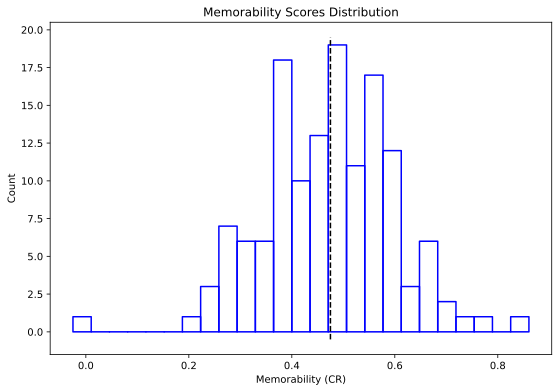

In [12]:
plt.figure(figsize=(9,6))
sns.histplot(CR_1a, color="blue", fill=False, bins=25)
plt.vlines(np.median(CR_1a), -0.5, 19.5, colors='black', linestyles='dashed')
plt.title("Memorability Scores Distribution")
plt.xlabel("Memorability (CR)")
plt.show()

# Expt 2B

In [13]:
mem_data_2b = pd.read_csv("data/Exp2B.csv")
mem_data_2b.head(2)

,Unnamed: 0,Title,Keywords,CreationTime,WorkTimeInSeconds,Answer.Submit.HIT,Answer.age,Answer.comment,Answer.education,Answer.ending,Answer.ethnicity,Answer.gender,Answer.imseq,Answer.imtypeseq,Answer.perfseq,Answer.quiz_1,Answer.quiz_2,Answer.quiz_3
0,1,Memory test for word(s),"Memory, words, food, cognitive test",Mon Jun 07 13:36:18 PDT 2021,1614,Submit HIT,27,{},Bachelor,completed,Native American,Male,"mini muffins,+,corn on the cob,+,grapefruit,+,...","1,0,3,0,3,0,3,0,3,0,3,0,4,0,3,0,3,0,1,0,3,0,4,...","14,0,14,0,14,0,14,0,14,0,14,0,11,0,14,0,14,0,1...",Correct,Correct,Correct
1,3,Memory test for word(s),"Memory, words, food, cognitive test",Mon Jun 07 13:36:18 PDT 2021,789,Submit HIT,30,NaN,Bachelor,completed,Caucasian,Female,"cocktail shrimp,+,rice and beans,+,cheez-its,+...","3,0,1,0,3,0,3,0,3,0,4,0,3,0,3,0,1,0,3,0,3,0,4,...","14,0,14,0,14,0,14,0,14,0,12,0,14,0,14,0,14,0,1...",Correct,Correct,Correct


In [14]:
mem_pre_2b = preprocess(2, mem_data_2b)

In [15]:
mem_pre_2b.shape

(195, 138, 4)

In [16]:
per_image_2b = mem_pre_2b.sum(axis=0)

In [17]:
HR_2b = per_image_2b[:, 1] / per_image_2b[:, 0]
FAR_2b = per_image_2b[:, 2] / (per_image_2b[:, 2] + per_image_2b[:, 3])
CR_2b = HR_2b - FAR_2b

In [18]:
CR_2b

array([ 0.44186047,  0.09090909,  0.3       ,  0.5       ,  0.53658537,
        0.36585366,  0.09090909,  0.1       ,  0.125     ,  0.075     ,
        0.4       ,  0.29268293,  0.21428571,  0.51219512,  0.2       ,
        0.42857143,  0.45238095,  0.20512821,  0.36363636,  0.26315789,
        0.16666667,  0.07317073,  0.17948718,  0.275     ,  0.1627907 ,
        0.07894737,  0.31707317,  0.23809524,  0.15      ,  0.41463415,
        0.33333333,  0.17073171,  0.19512195,  0.26315789,  0.31111111,
        0.11627907,  0.32608696,  0.11627907,  0.4047619 ,  0.5       ,
        0.28205128,  0.35897436,  0.39534884,  0.14634146,  0.41463415,
        0.175     ,  0.3255814 ,  0.15      ,  0.2       ,  0.29268293,
        0.12820513,  0.23076923,  0.33333333,  0.17073171,  0.07317073,
        0.33333333,  0.31707317,  0.        ,  0.12820513,  0.18181818,
        0.2195122 ,  0.46511628,  0.17948718,  0.        ,  0.58536585,
        0.55      ,  0.25641026,  0.35      ,  0.39534884,  0.19

In [19]:
pd.Series(CR_2b).describe()

count    138.000000
mean       0.261401
std        0.123317
min       -0.025000
25%        0.179487
50%        0.253205
75%        0.341806
max        0.585366
dtype: float64

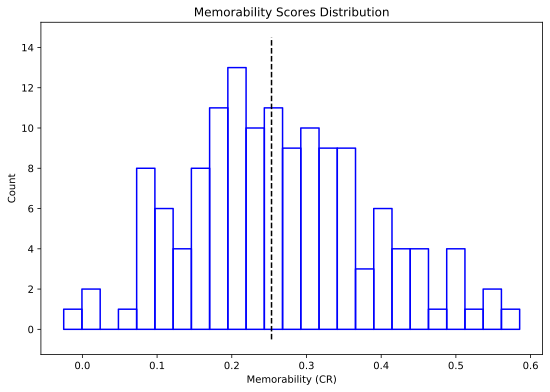

In [20]:
plt.figure(figsize=(9,6))
sns.histplot(CR_2b, color="blue", fill=False, bins=25)
plt.vlines(np.median(CR_2b), -0.5, 14.5, colors='black', linestyles='dashed')
plt.title("Memorability Scores Distribution")
plt.xlabel("Memorability (CR)")
plt.show()

---


In [21]:
def half_split(data):
    
    group1 = np.zeros((1000, 138))
    group2 = np.zeros((1000, 138))
    corr = np.zeros((1000, 2))
    
    for i in range(1000):
        
        np.random.shuffle(data)
        g1, g2 = np.array_split(data, 2)
        
        per_image_g1 = g1.sum(axis=0)
        per_image_g2 = g2.sum(axis=0)
        
        HR_g1 =  per_image_g1[:, 1] / per_image_g1[:, 0]
        FAR_g1 = per_image_g1[:, 2] / (per_image_g1[:, 2] + per_image_g1[:, 3])
        
        HR_g2 =  per_image_g2[:, 1] / per_image_g2[:, 0]
        FAR_g2 = per_image_g2[:, 2] / (per_image_g2[:, 2] + per_image_g2[:, 3])
        
        CR_g1 = HR_g1 - FAR_g1
        CR_g2 = HR_g2 - FAR_g2
        
        group1[i] = CR_g1
        group2[i] = CR_g2

        corr[i, 0], corr[i, 1] = spearmanr(CR_g1, CR_g2)
        
    return group1, group2, corr

In [22]:
group1_1a, group2_1a, corr_1a = half_split(mem_pre_1a)

In [23]:
corr_1a[:, 0].mean()

0.2929778596859416

In [24]:
pd.Series(corr_1a[:, 1]).describe()

count    1.000000e+03
mean     4.147223e-03
std      1.529629e-02
min      7.766480e-09
25%      6.436992e-05
50%      5.044297e-04
75%      2.808472e-03
max      3.713530e-01
dtype: float64

In [25]:
mean1_1a = group1_1a.mean(axis=0)
mean2_1a = group2_1a.mean(axis=0)

In [26]:
order = np.argsort(mean1_1a)

In [27]:
df_1a = pd.DataFrame({
    "rank": np.arange(1, 139),
    "mean1": mean1_1a[order][::-1],
    "mean2": mean2_1a[order][::-1],
})

Text(0.5, 1.0, 'Split-Half Reliability $(\\rho=0.29, )$')

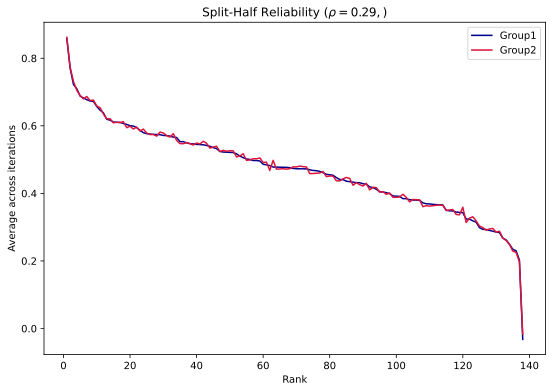

In [28]:
plt.figure(figsize=(9,6))
plt.plot(df_1a["rank"], df_1a["mean1"], color="darkblue", label="Group1")
plt.plot(df_1a["rank"], df_1a["mean2"], color="crimson", label="Group2")
plt.legend()
plt.xlabel("Rank")
plt.ylabel("Average across iterations")
plt.title(r"Split-Half Reliability $(\rho=0.29, )$")

In [29]:
group1_2b, group2_2b, corr_2b = half_split(mem_pre_2b)

In [30]:
corr_2b[:, 0].mean()

0.2554885902338318

In [31]:
mean1_2b = group1_2b.mean(axis=0)
mean2_2b = group2_2b.mean(axis=0)

In [32]:
order = np.argsort(mean1_2b)

In [33]:
df_2b = pd.DataFrame({
    "rank": np.arange(1, 139),
    "mean1": mean1_2b[order][::-1],
    "mean2": mean2_2b[order][::-1],
})

In [34]:
spearmanr(mean1_2b, mean2_2b)

SignificanceResult(statistic=0.9977488019105502, pvalue=1.7228560603243948e-161)

Text(0.5, 1.0, 'Split-Half Reliability $(\\rho=0.25, )$')

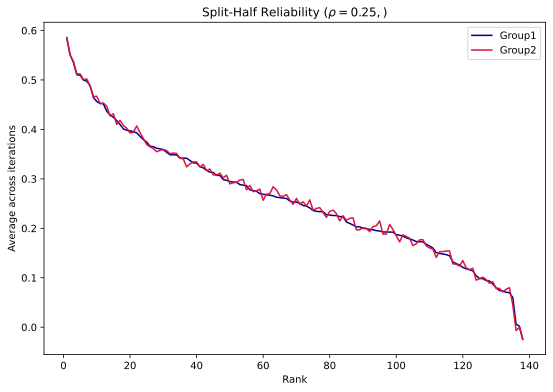

In [35]:
plt.figure(figsize=(9,6))
plt.plot(df_2b["rank"], df_2b["mean1"], color="darkblue", label="Group1")
plt.plot(df_2b["rank"], df_2b["mean2"], color="crimson", label="Group2")
plt.legend()
plt.xlabel("Rank")
plt.ylabel("Average across iterations")
plt.title(r"Split-Half Reliability $(\rho=0.25, )$")

---

In [52]:
CR_1a


array([ 0.36585366,  0.29268293,  0.54545455,  0.6097561 ,  0.54761905,
        0.36585366,  0.34090909,  0.6097561 ,  0.4       ,  0.475     ,
        0.70731707,  0.38095238,  0.6097561 ,  0.46341463,  0.425     ,
        0.42857143,  0.48780488,  0.44186047,  0.6       ,  0.55      ,
        0.31818182,  0.45238095,  0.56097561,  0.36585366,  0.58536585,
        0.65853659,  0.42857143,  0.41463415,  0.65      ,  0.46341463,
        0.52380952,  0.57777778,  0.35      ,  0.5       ,  0.47619048,
        0.575     ,  0.54761905,  0.5952381 ,  0.55      ,  0.51111111,
        0.6744186 ,  0.61904762,  0.575     ,  0.3902439 ,  0.23255814,
        0.45238095,  0.6097561 ,  0.22727273,  0.3902439 ,  0.43902439,
        0.5       ,  0.48837209,  0.28571429,  0.37777778,  0.55      ,
        0.6       ,  0.63636364,  0.46341463,  0.41463415,  0.29268293,
        0.44186047,  0.57142857,  0.51111111,  0.34090909,  0.68888889,
        0.46341463,  0.26829268,  0.72727273,  0.47619048,  0.57

In [83]:
from scipy.stats import permutation_test
from scipy.stats import ks_2samp
import scipy.stats
ks = ks_2samp(CR_1a, CR_2b)
ks

KstestResult(statistic=0.6376811594202898, pvalue=1.1056834264280294e-26, statistic_location=0.36363636363636365, statistic_sign=-1)

In [86]:
corr_test = scipy.stats.spearmanr(CR_1a,CR_2b)
corr_test

SignificanceResult(statistic=0.13395970492722364, pvalue=0.11724914199971041)

In [91]:
from scipy.stats import mannwhitneyu

In [92]:
def ks_stat(X,y):
    ks = ks_2samp(X, y)
    return ks.statistic

def corr_stat(X,y):
    return scipy.stats.spearmanr(X, y).statistic

def mannu_stat(X,y):
    return mannwhitneyu(X,y).statistic

In [67]:
res = permutation_test((CR_1a, CR_2b), permutation_type ='samples', statistic=ks_stat, n_resamples=10000)

In [68]:
res

PermutationTestResult(statistic=0.6376811594202898, pvalue=0.00019998000199980003, null_distribution=array([0.21014493, 0.1884058 , 0.12318841, ..., 0.15942029, 0.05072464,
       0.07971014]))

In [90]:
res2 = permutation_test((CR_1a, CR_2b), permutation_type ='samples', statistic=corr_stat, n_resamples=10000)
res2

PermutationTestResult(statistic=0.13395970492722364, pvalue=0.00019998000199980003, null_distribution=array([-0.34358905, -0.35288409, -0.346525  , ..., -0.35892099,
       -0.34905342, -0.35213128]))

In [93]:
res3 = permutation_test((CR_1a, CR_2b), permutation_type ='samples', statistic=mannu_stat, n_resamples=10000)
res3

PermutationTestResult(statistic=16803.0, pvalue=0.00019998000199980003, null_distribution=array([ 8953.5, 10378.5,  9851.5, ...,  8418. ,  9703. ,  7913.5]))

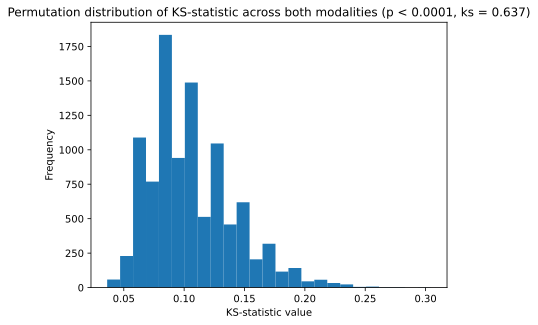

In [96]:
import matplotlib.pyplot as plt

plt.hist(res.null_distribution, bins=25)

plt.title("Permutation distribution of KS-statistic across both modalities (p < 0.0001, ks = 0.637)")

plt.xlabel("KS-statistic value")

plt.ylabel("Frequency")
plt.savefig("ks.png")
plt.show()

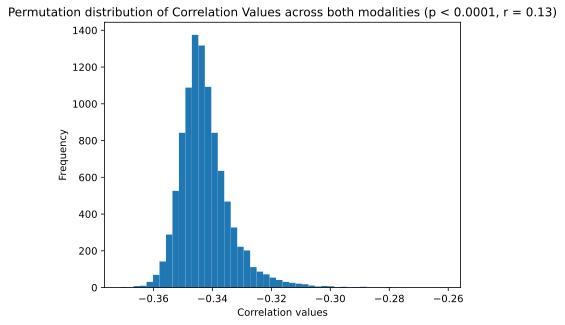

In [82]:
import matplotlib.pyplot as plt

plt.hist(res2.null_distribution, bins=50)

plt.title("Permutation distribution of Correlation Values across both modalities (p < 0.0001, r = 0.13)")
plt.xlabel("Correlation values")
plt.ylabel("Frequency")
plt.show()